# *Europe Waste generation and treatment*

## How committed are we to reduce our waste generation and become more sustainable?

To understand if we are really committed to a more sustainable life, we are going to deep into some data about waste generation and treatment within Europe. with a closer focus on EU plus UK.

## Data description

On the basis of the Regulation on waste statistics (EC) No. 2150/2002, amended by Commission Regulation (EU) No. 849/2010, data on the generation and treatment of waste is collected from the Member States. The information on waste generation has a breakdown in sources (19 business activities according to the NACE classification and household activities) and in waste categories (according to the European Waste Classification for statistical purposes). The information on waste treatment is broken down to treatment types (recovery, incineration with energy recovery, other incineration, disposal on land and land treatment) and in waste categories.

All values are measured in tonnes of waste and in kg per capita, based on the annual average of the population.For and easier interpretation we are including the measured in million of tonnes.

The Member States are free to decide on the data collection methods.

For the first reference year 2004 Member States could apply for permission not to deliver part of the information: waste generated by agriculture and fishing and waste generated in the services sector. For this reason this information is missing for some of the countries.

Source: 
https://ec.europa.eu/eurostat/databrowser/product/view/ENV_WASGEN?lang=en

### Classification system

The domain consists of two data sets: Generation of waste and treatment of waste. The data set on the generation of waste is broken down into waste categories and the source of waste generation; the data set on the treatment of waste is broken down into the type of treatment and waste category. 

Waste categories:

The data sets contain a breakdown into waste categories according to the European Waste Classification for statistical purposes: EWC-Stat. The classification is linked to the administrative classification List of Wastes: List of wastes.

Source of waste generation:

The generation of waste is attributed to either production or consumption activities. The actor handing over the waste to the waste management system is regarded as the source. For production activities a further breakdown is supplied in economic activities according to the NACE rev. 2 classification. In addition to the waste generated by businesses waste is generated by households.

 
Treatment types:

On the basis of the treatment operations defined in Directive 2008/98/EC a distinction is made in treatment types.The treatment operation is linked to the classification List of Waste generated: List of wastes operation code.


## Starting the analysis

With Pandas we are going to clean the data. Some of the information on our dataset is duplicated, we will only  keep some nace codes (business activities) in the waste generation  dataset and some waste treatment operation codes.
We keep only the columns relevant to our analysis and reshape the dataframe.

In [2]:
#Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

plt.style.use('seaborn')

In [3]:
#Read all Dataframes
wasgen = pd.read_csv('../Documents/env_wasgen_linear.csv.gz')
wastrt = pd.read_csv('../Documents/env_wastrt_linear.csv.gz')
waste_code = pd.read_csv('../Documents/ESTAT_WASTE_en.tsv', sep='\t')
geo_code = pd.read_csv('../Documents/ESTAT_GEO_en.tsv', sep='\t')
nace_code = pd.read_csv('../Documents/ESTAT_NACE_R2_en.tsv', sep='\t')
wst_oper_code = pd.read_csv('../Documents/ESTAT_WST_OPER_en.tsv', sep='\t')

In [36]:
#Cleaning and reshaping DataFrame
list_nace_r2 = ['A','B','C','D','E','EP_HH','F','G4677','G-U_X_G4677','TOTAL_HH']
wasgen_df = wasgen.filter(['hazard','waste','nace_r2','geo','TIME_PERIOD','unit','OBS_VALUE'])\
    .dropna().query(f'hazard == "HAZ_NHAZ" and nace_r2 in {list_nace_r2} ', engine = 'python')\
    .pivot(index=['hazard','waste','nace_r2','geo','TIME_PERIOD'],\
           columns = 'unit', values = 'OBS_VALUE')\
    .reset_index().query('KG_HAB > 0 or T > 0').rename(columns = lambda column : column.lower())\
    .assign(mill_tons = lambda dataset: dataset.t / 1000000,\
            time_period = lambda dataset: pd.to_datetime(dataset.time_period,format = '%Y'))\
    .rename(columns ={'t':'tons'})


In [58]:
#Cleaning and reshaping DataFrame
list_wst_oper=['DSP_I','DSP_L_OTH','RCV_R_B','RCV_E','TRT']

wastrt_df = wastrt.filter(['hazard','waste','wst_oper','geo','TIME_PERIOD','unit','OBS_VALUE'])\
    .dropna().query(f'hazard == "HAZ_NHAZ" and wst_oper in {list_wst_oper}', engine = 'python')\
    .pivot(index=['hazard','waste','wst_oper','geo','TIME_PERIOD'],\
           columns = 'unit', values = 'OBS_VALUE')\
    .reset_index().query('KG_HAB > 0 or T > 0').rename(columns = lambda column : column.lower())\
    .assign(mill_tons = lambda dataset: dataset.t / 1000000,\
           time_period = lambda dataset: pd.to_datetime(dataset.time_period,format = '%Y'),
           treatment_type = lambda dataset: dataset.wst_oper\
            .map(lambda value :'Recovery' if bool(re.search('^RCV',value))\
                 else ('Waste treatment' if value == 'TRT' else 'Disposal')))\
    .rename(columns ={'t':'tons'})

In [6]:
#Cleaning and reshaping DataFrame
geo_code= geo_code.rename(columns = {'EUR':'geo', 'Europe':'country'})
nace_code =nace_code.rename(columns = {'TOTAL': 'nace_r2',\
                                       'Total - all NACE activities':'Industry'})
wst_oper_code=wst_oper_code.rename(columns = {'GEN':'wst_oper'})

## Data Analysis
With our data ready to go, we will create some visualizations to ease the analysis.  
We will focus on the waste generation by country and the evolution through the years and on the different treatment types. 


In [25]:
total_generation_2018 = wasgen_df.query('waste == "TOTAL" and time_period == 2018 and nace_r2 =="TOTAL_HH" and geo not in ["EU28","EU27_2020"]')\
    .mill_tons.sum().round(2)
total_generation_2018 

2796.74

#### Waste Generation by Country
The total waste generated within the scoupe of this analysis during the year 2018 was of 2.796,74 million tons.
Here we can see the top 10 countries that contribute to this. This 10 countries represent the 76% of the total. Considering that we are evaluating 38 different countries, the concentration on just this 10 is considerable.

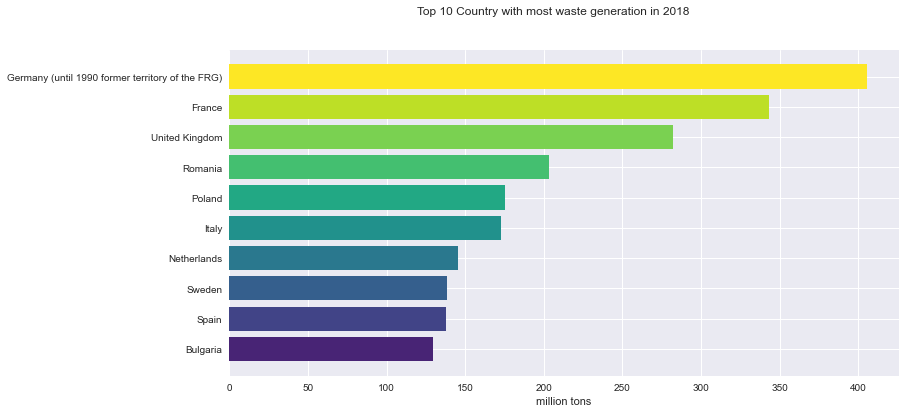

In [75]:
#Top 10 country in EUR with more waste generation
Top_10_2018 = wasgen_df.query('waste == "TOTAL" and time_period == 2018 and nace_r2 =="TOTAL_HH" ')\
    .groupby('geo').sum()\
    .sort_values('mill_tons', ascending = False)\
    .reset_index().query('geo not in ["EU28","EU27_2020"]', engine = 'python')\
    .head(10).merge(geo_code, on = 'geo', how ='left')\
    .filter(['geo','country','mill_tons'])
fig, ax = plt.subplots(figsize = (12,6))
fig.suptitle ('Top 10 Country with most waste generation in 2018')
cmap = plt.get_cmap("viridis")
colors =cmap([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

ax.barh('country','mill_tons', data = Top_10_2018.sort_values('mill_tons'), color = colors)
ax.set_xlabel('million tons');

In [76]:
Top_10_2018.mill_tons.sum()/total_generation_2018*100

76.29245321338416

If we focus on the 14-year evolution of the waste generation, we can find some interesting insights. Germany has always been the first waste generator, and been increasing the volummen ever since.
One country that has been decreasing his waste generation is Bulgaria. We must bear in mind that our data includes the waste generated for construction activities and in general this is a significant amount over the total.If we exclude the major mineral waste, Bulgaria's evolution is more stable.

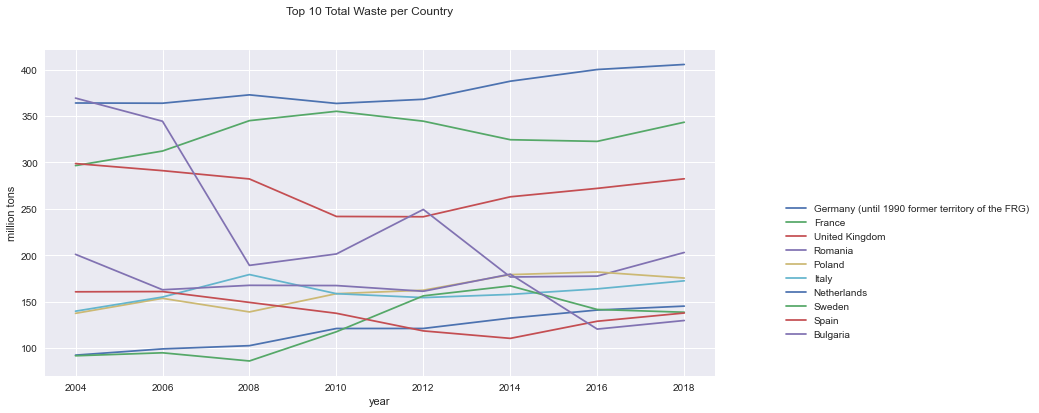

In [77]:
Lista_top_10 = Top_10_2018.country.tolist()

fig, ax = plt.subplots(figsize =(12,6))
fig.suptitle('Top 10 Total Waste per Country')
for i in Lista_top_10:
    evol_i = wasgen_df.query('waste == "TOTAL" and nace_r2 =="TOTAL_HH" ')\
        .groupby(['geo', 'time_period']).sum()\
        .reset_index().merge(geo_code, on = 'geo', how ='left')\
        .query(f'country == "{i}"', engine = 'python')\
        .filter(['country','time_period','mill_tons'])
    
    ax.plot('time_period', 'mill_tons', data= evol_i, label = i )
    ax.legend(loc= (1.1,0.1) )

ax.set_ylabel('million tons')
ax.set_xlabel('year') ;  

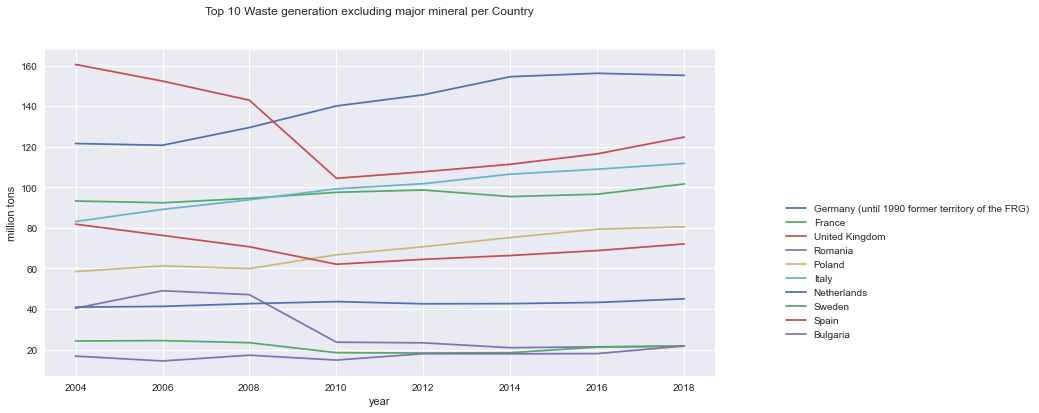

In [78]:

fig, ax = plt.subplots(figsize =(12,6))
fig.suptitle('Top 10 Waste generation excluding major mineral per Country')
for i in Lista_top_10:
    evol_i = wasgen_df.query('waste == "TOT_X_MIN" and nace_r2 =="TOTAL_HH" ')\
        .groupby(['geo', 'time_period']).sum()\
        .reset_index().merge(geo_code, on = 'geo', how ='left')\
        .query(f'country == "{i}"', engine = 'python')\
        .filter(['country','time_period','mill_tons'])
    
    ax.plot('time_period', 'mill_tons', data= evol_i, label = i )
    ax.legend(loc= (1.1,0.1) )

ax.set_ylabel('million tons')
ax.set_xlabel('year') ;  

Considering the total waste generation is related to the population of the country, we should evaluate the generation per capita.
In the 2018, this approach changes our top 10 countries.

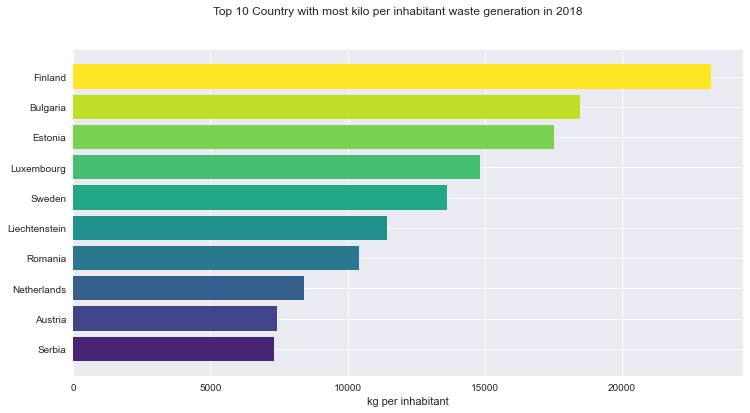

In [79]:
#Top 10 country in EUR with more waste generation per capita
Top_10_2018_kg_hab = wasgen_df.query('waste == "TOTAL" and time_period == 2018 and nace_r2 =="TOTAL_HH" ')\
    .groupby(['geo']).sum()\
    .sort_values('kg_hab', ascending = False)\
    .reset_index().query('geo not in ["EU28","EU27_2020"]', engine = 'python')\
    .head(15).merge(geo_code, on = 'geo', how ='left')\
    .filter(['country','time_period','kg_hab']).head(10)

fig, ax = plt.subplots(figsize = (12,6))
fig.suptitle ('Top 10 Country with most kilo per inhabitant waste generation in 2018')


ax.barh('country','kg_hab', data = Top_10_2018_kg_hab.sort_values('kg_hab'), color = colors)
ax.set_xlabel('kg per inhabitant');



#### Waste generation by Activity
Now we'll take a look into the activities that generate the waste.Considering the year 2018 evaluating the EU plus UK. 

Construction contributed 37.27 % of the total in 2018 and was followed by mining and quarrying with a 24.26 %, only those two activities cover more than 60% of the total waste generation.
The activity that involves us directly is Households and it represent a 8.35% with a total of 218,72 million tons of waste. A figure, not at all despicable. 


In [80]:
#Waste Generation by industries

Total_HH = wasgen_df.query('waste == "TOTAL" and time_period == 2018 and geo  == "EU28" and nace_r2 == "TOTAL_HH" ').mill_tons.sum()
Top_ind_2018 = wasgen_df.query('waste == "TOTAL" and time_period == 2018 and geo  == "EU28" ')\
    .groupby(['nace_r2']).sum()\
    .sort_values('mill_tons', ascending = False)\
    .reset_index().query('nace_r2 not in ["TOTAL_HH"]', engine = 'python')\
    .merge(nace_code, on = 'nace_r2', how ='left')\
    .filter(['Industry','mill_tons']).assign(Total_perc = lambda dataset : round(dataset.mill_tons / Total_HH * 100,2))
Top_ind_2018



,Industry,mill_tons,Total_perc
0,Construction,976.70,37.27
1,Mining and quarrying,635.68,24.26
2,"Water supply; sewerage, waste management and r...",273.72,10.45
3,Manufacturing,257.80,9.84
4,Households,218.72,8.35
5,Services (except wholesale of waste and scrap),128.39,4.90
6,"Electricity, gas, steam and air conditioning s...",79.05,3.02
7,Wholesale of waste and scrap,29.48,1.13
8,"Agriculture, forestry and fishing",20.87,0.80


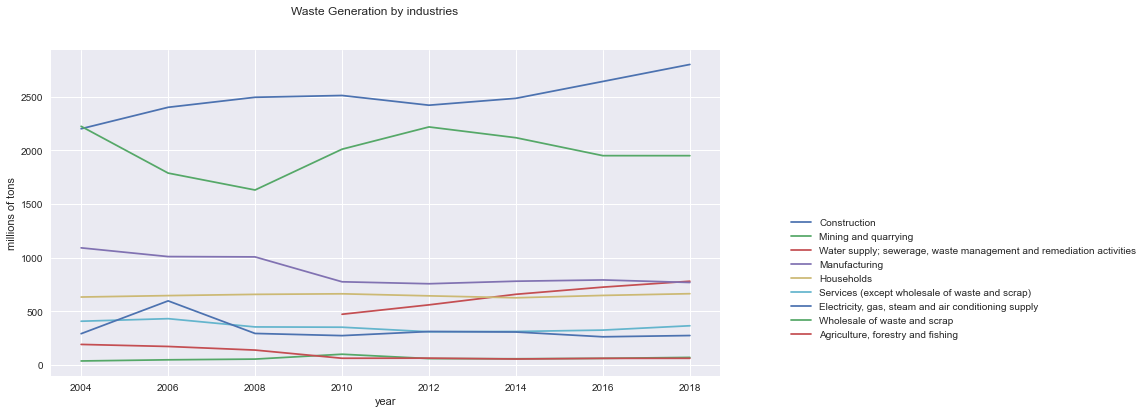

In [81]:
Lista_top_ind = Top_ind_2018.Industry.tolist()

fig, ax = plt.subplots(figsize =(12,6))
fig.suptitle('Waste Generation by industries')

for i in Lista_top_ind:
    
    evol_ind_i = wasgen_df.query('waste == "TOTAL"')\
    .groupby(['nace_r2','time_period']).sum()\
    .reset_index().merge(nace_code, on = 'nace_r2', how ='left').query(f'Industry == "{i}"', engine = 'python')\
    .filter(['time_period','Industry','mill_tons'])
    
    ax.plot('time_period', 'mill_tons', data= evol_ind_i, label = i )
    ax.legend(loc= (1.1,0.1) )

ax.set_ylabel('millions of tons')
ax.set_xlabel('year') ;

#### Waste treatment

As much as we want to reduce the waste generation, we know it is imposible to completly avoid it.But in order to be more environmentally friendly, we can find the best way to treat our garbage.
We can clustered the different type of waste treatment into two groups. 

-***Disposal*** : This group includes the landfill and the incineration.

-***Recovery*** : Here we have the recycling and all the traetments that give the garbage a new use.

By this two definitions we can argue that the second one, **recovery** is what we should promote.


In [82]:
#waste treatment type
wastrt_df.query('waste == "TOTAL" and geo not in ["EU28","EU27_2020"] and time_period == 2018 ', engine = 'python')\
    .groupby('wst_oper').sum().reset_index().sort_values('mill_tons', ascending = False)\
    .merge(wst_oper_code, how ='left', on = 'wst_oper').filter(['Waste generated','mill_tons'])

,Waste generated,mill_tons
0,Waste treatment,2586.302336
1,"Disposal - landfill and other (D1-D7, D12)",1187.436590
2,Recovery - recycling and backfilling (R2-R11),1186.635047
3,Recovery - energy recovery (R1),139.498726
4,Disposal - incineration (D10),21.643730


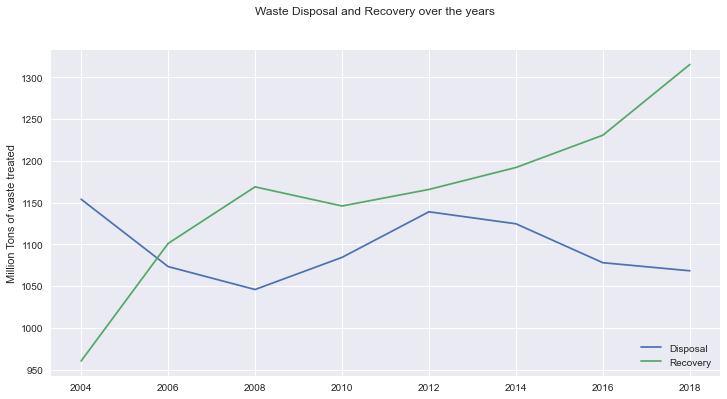

In [83]:
trt_dis_rec = wastrt_df.query('waste == "TOTAL" and geo == ["EU28"] ')\
             .groupby(['time_period','treatment_type']).sum().reset_index()\
             .filter(['time_period','treatment_type','mill_tons'])

trt_dis = trt_dis_rec.query('treatment_type == "Disposal" ')
trt_rec = trt_dis_rec.query('treatment_type == "Recovery" ')

fig, ax = plt.subplots(figsize = (12,6))
fig.suptitle('Waste Disposal and Recovery over the years')

ax.plot('time_period','mill_tons', data = trt_dis, label = 'Disposal' )
ax.plot('time_period','mill_tons', data = trt_rec, label = 'Recovery' )
plt.ylabel('Million Tons of waste treated')
ax.legend(loc = 4);


In [84]:
#Europe treatment and generations of waste through time

trt_eu28 = wastrt_df.query('waste == "TOTAL" and geo == "EU28"')\
         .groupby(['time_period','treatment_type'],as_index=False).sum()\
         .filter(['time_period','geo','treatment_type','mill_tons'])

disp = trt_eu28.query('treatment_type == "Disposal"')
recy = trt_eu28.query('treatment_type == "Recovery"')

gen_eu28 = wasgen_df.query('waste == "TOTAL" and geo == "EU28" and nace_r2 =="TOTAL_HH" ')\
         .groupby(['time_period'],as_index=False).sum()\
         .filter(['time_period','geo','mill_tons'])


#### Waste Generation versus Waste treatment 

Is a good sign that the recovery is incresing over the waste disposal. If we compare the waste generation into the EU (consideringo also UK), opposite to the waste treated, we can see that not all the waste that is generated is treated.

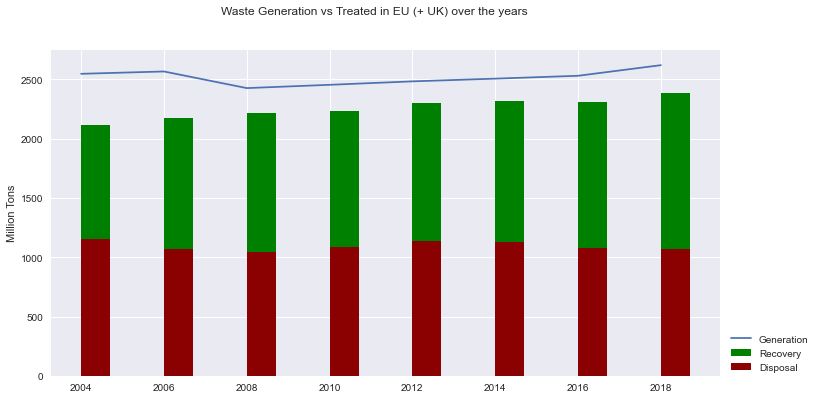

In [85]:
fig, axs =plt.subplots(figsize = (12,6))
fig.suptitle('Waste Generation vs Treated in EU (+ UK) over the years')

xlabels = gen_eu28.time_period.dt.year.tolist()
x = np.arange(len(xlabels))  # the label locations


axs.plot(x, 'mill_tons', data = gen_eu28, label = 'Generation' )
axs.bar(x, 'mill_tons',data = recy, bottom = disp.mill_tons, label = 'Recovery',width = 0.35,align = 'edge', color = 'green',tick_label=xlabels)
axs.bar(x, 'mill_tons',data = disp, label = 'Disposal', width = 0.35,align = 'edge', color = 'darkred')
plt.ylabel('Million Tons')
axs.legend(loc= (1.01,0.0));
#axs.bar(x, 'mill_tons', data = gen_eu28, label = 'Generation' ,width = -0.35,align = 'edge',tick_label=xlabels)

In [86]:
#By Top waste generating country. Total generation, genetarion per capital vs waste treated in 2018

gen_country = wasgen_df.query('waste == "TOTAL" and time_period == 2018 and nace_r2 =="TOTAL_HH"')\
    .groupby('geo').sum().sort_values('mill_tons', ascending = False)\
    .reset_index().query('geo not in ["EU28","EU27_2020"]', engine = 'python')
trt_country = wastrt_df.query('waste == "TOTAL" and time_period == 2018 and wst_oper == "TRT" ')\
            .groupby(['geo']).sum()\
            .reset_index().query('geo not in ["EU28","EU27_2020"]', engine = 'python')\
            .rename(columns = {'mill_tons':'mill_tons_trt'})\
            .filter(['geo','mill_tons_trt'])
unif2 = gen_country.merge(trt_country, how= 'left', on = 'geo').merge(geo_code, on = 'geo', how ='left').head(10)


In [87]:
#By Top waste generating country. Total generation, genetarion per capital vs waste Recovery in 2018

gen_country = wasgen_df.query('waste == "TOTAL" and time_period == 2018 and nace_r2 =="TOTAL_HH"')\
    .groupby('geo').sum().sort_values('mill_tons', ascending = False)\
    .reset_index().query('geo not in ["EU28","EU27_2020"]', engine = 'python')
rec_country = wastrt_df.query('waste == "TOTAL" and time_period == 2018 and treatment_type == "Recovery"')\
            .groupby(['geo']).sum()\
            .reset_index().query('geo not in ["EU28","EU27_2020"]', engine = 'python')\
            .rename(columns = {'mill_tons':'mill_tons_trt'})\
            .filter(['geo','mill_tons_trt'])
unif = gen_country.merge(rec_country, how= 'left', on = 'geo').merge(geo_code, on = 'geo', how ='left').head(10)


So far we have identified the main waste generators countries, we review the activities that have the greatest impact on the generations of waste, and defined and measured what is done with that waste.

Now we are going to compare the top 10 countries their waste generation rate, how much they treat in total and by the circle size we will see the kg per capita of waste generation.
We included the same plot, but considering only recovery.

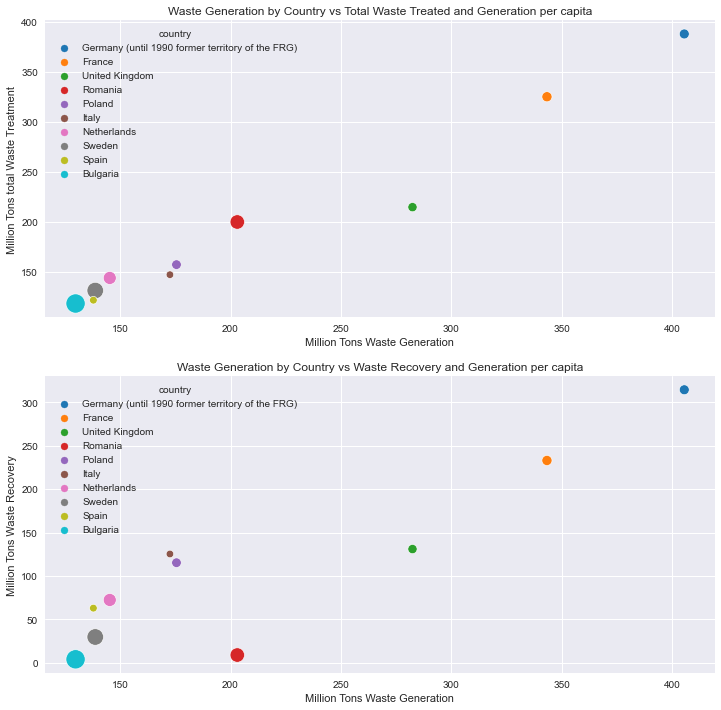

In [88]:
fig, ax = plt.subplots (2, figsize= ( 12,12))

tamaño = unif.kg_hab/50

sns.scatterplot (x = 'mill_tons',y = 'mill_tons_trt',data = unif, s = tamaño, hue = unif.country,palette = 'tab10', ax = ax[1]);
ax[1].set_xlabel('Million Tons Waste Generation')
ax[1].set_ylabel('Million Tons Waste Recovery')
ax[1].set_title('Waste Generation by Country vs Waste Recovery and Generation per capita')

sns.scatterplot (x = 'mill_tons',y = 'mill_tons_trt',data = unif2, s = tamaño, hue = unif.country,palette = "tab10",ax = ax[0])
ax[0].set_xlabel('Million Tons Waste Generation')
ax[0].set_ylabel('Million Tons total Waste Treatment')
ax[0].set_title('Waste Generation by Country vs Total Waste Treated and Generation per capita');

One insight we obtain from this chart is that exist a positive correlation between the waste generation and the waste treatment. Romania is one of the countries that treat almost all its waste, but mostly through disposal.  

## Conclusions

Sustainability is a broad subject and can be broken down into many different sections that all affect our lives on a day to day basis.
A quick look at the European waste treatments  tells us that the main methods of waste disposal are landfill, incineration and recycling. Few would argue against recycling, but a fierce debate continues between landfill and incineration. The main problem with landfill, apart from the obvious space and odor issues, is the production of methane. Seen that the treatment by recovery is increasing over the disposal is a sign that things are changing towards a better alternative.



In this Github repository you will find the notebook with the complete code. And also all the datasets.
https://github.com/eloisacorti/Waste_analysis